# Action and Policy
This section will discuss how to control the vehicle in MetaDrive with the *Policy* interface. Before this, let's have a look at the raw control signal required by vehicles.

## Action

To control vehicles in MetaDrive, the input should be a normalized action: $\mathbf a = [a_1, a_2] \in [-1, 1]^2$. This action is converted into the steering $u_s$ (degree), acceleration $u_a$ (hp) and brake signal $u_b$ (hp) in the following ways:

$u_s = S_{max} a_1$  
$u_a = F_{max} \max(0, a_2)$  
$u_b = -B_{max} \min(0, a_2)$  

wherein $S_{max}$ (degree) is the maximal steering angle, $F_{max}$ (hp) is the maximal engine force, and $B_{max}$ (hp) is the maximal brake force. 
To increase diversity, the accurate values of these parameters are varying across different vehicle but are limited to certain ranges defined by [VehicleParameterSpace](https://github.com/metadriverse/metadrive/blob/main/metadrive/utils/space.py).

The steering $u_s$ is applied to two front wheels. In addition, the engine force $u_a$ and the brake force $u_b$ are applied to four wheels, as the car in MetaDrive is four-wheel drive (4WD). The concrete implementation is as follows:

In [52]:
from metadrive.component.vehicle.base_vehicle import BaseVehicle
import inspect
from textwrap import dedent
print(dedent(inspect.getsource(BaseVehicle._set_action)))
print(dedent(inspect.getsource(BaseVehicle._apply_throttle_brake)))

def _set_action(self, action):
    if action is None:
        return
    steering = action[0]
    self.throttle_brake = action[1]
    self.steering = steering
    self.system.setSteeringValue(self.steering * self.max_steering, 0)
    self.system.setSteeringValue(self.steering * self.max_steering, 1)
    self._apply_throttle_brake(action[1])

def _apply_throttle_brake(self, throttle_brake):
    max_engine_force = self.config["max_engine_force"]
    max_brake_force = self.config["max_brake_force"]
    for wheel_index in range(4):
        if throttle_brake >= 0:
            self.system.setBrake(2.0, wheel_index)
            if self.speed_km_h > self.max_speed_km_h:
                self.system.applyEngineForce(0.0, wheel_index)
            else:
                self.system.applyEngineForce(max_engine_force * throttle_brake, wheel_index)
        else:
            if self.enable_reverse:
                self.system.applyEngineForce(max_engine_force * throttle_brake, wheel_index)
            

Actually, you can make the car 2WD or 4 wheel steering or even increasing its number of wheels by implementing a new vehicle type like `BaseVehicle`.

The aforementioned `_set_action(self, action)` function is wrapped by the `before_step(self, action)` function, which will do additional manipulations like numerical validation. Thus to control a vehicle, just set the action through `vehicle.before_step(target_action)` before simulating the next step. A minimal example to control a vehicle is as follows. The script first creates a new vehicle in front of the green ego car and set its action as `[0, 0.05]` at each step. As a result, it slowly moves forward, while the green ego car stops at the origin as its input action is always `[0, 0]`. 

In [ ]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.component.vehicle.vehicle_type import DefaultVehicle

env=MetaDriveEnv(dict(map="S", traffic_density=0))
try:
    env.reset()
    cfg=env.config["vehicle_config"]
    cfg["navigation"]=None # it doesn't need navigation system
    v = env.engine.spawn_object(DefaultVehicle, vehicle_config=cfg, position=[30,0], heading=0)
    for _ in range(500):
        v.before_step([0, 0.05])
        env.step([0,0])
        env.render(mode="topdown", screen_size=(800, 400),camera_position=(60,10))
finally:
    env.close()

## Policy

Generally, we want to control the vehicle in several ways besides providing raw action. For example, we may want to have an intermediate controller to turn the high-level driving commands into the low-level steering, throttle and brake signals. MetaDrive thus provides such an interface called *Policy*. The output of any *Policy* is supposed to be the raw signals taken by `vehicle.before_step` as input. To make such driving decisions, *Policy* can access all simulation information such as the map and all other objects as well as the external input signals from `env.step`. This allows us to make either an intermediate controller or a self-contained self-driving policy like `IDMPolicy`. Let's firstly have a look at the abstract class `BasePolicy`.

In MetaDrive, every policy should inherit from `BasePolicy` and reimplement two core methods:
`act(self, *args, **kwargs)` and `def get_input_space(cls)`. The `policy.act()` method aims at making driving decisions and thus produces 2-dimension actions for controlling the vehicle. To this end, the policy is allowed to access all information in the driving scene through the simulation engine and the external input from `env.step`. This external input should be a vector whose shape is defined by `policy.get_input_space()`. Therefore, the method `get_input_space` actually defines the action space for the environment and returns arbitrary space of `gym.spaces`. To elaborate on this, we explains how we design `EnvInputPolicy` which converts the external input from `env.step` to continuous signls to control the vehicles.

### EnvInputPolicy
This policy allows us to use the vector `action` accepted by `env.step(action)` to control the vehicle directly. The vector can represent the 2-dimensional raw continuous action directly or discrete/multi-discrete actions. Thus for a environment using this policy to control the ego vehicle, the action space will be `gym.Box`, `gym.Discrete`, or `gym.MultiDiscrete`. 

In [53]:
from metadrive.policy.env_input_policy import EnvInputPolicy
from inspect import getsource
from textwrap import dedent
print(dedent(getsource(EnvInputPolicy.get_input_space)))

@classmethod
def get_input_space(cls):
    """
    The Input space is a class attribute
    """
    engine_global_config = get_global_config()
    discrete_action = engine_global_config["discrete_action"]
    discrete_steering_dim = engine_global_config["discrete_steering_dim"]
    discrete_throttle_dim = engine_global_config["discrete_throttle_dim"]
    use_multi_discrete = engine_global_config["use_multi_discrete"]

    if not discrete_action:
        _input_space = gym.spaces.Box(-1.0, 1.0, shape=(2, ), dtype=np.float32)
    else:
        if use_multi_discrete:
            _input_space = gym.spaces.MultiDiscrete([discrete_steering_dim, discrete_throttle_dim])
        else:
            _input_space = gym.spaces.Discrete(discrete_steering_dim * discrete_throttle_dim)
    return _input_space



According to the definition of `get_input_space`, one can use these configs to customize the input space of this policy as well as the action space for the environment:
```python
# the type of these config and the default value
discrete_action: bool = False
discrete_steering_dim: int = 5
discrete_throttle_dim: int = 5
use_multi_discrete: bool = False
```
By default, the action space for the environment is continuous action space bounded by `[-1, 1]`. Thus the external input, the action, will be used to control the vehicle directly. Also, you can change the action space to discrete action space by setting `discrete_action=True` when creating the environment. After that, there will be `discrete_steering_dim * discrete_throttle_dim` candidate actions that can be chosen by the external policy, i.e. a neural network for controlling the vehicle.

In [2]:
from metadrive.envs.base_env import BaseEnv
env=BaseEnv(dict(discrete_action=True, log_level=50))
num_candidates=env.config["discrete_steering_dim"]*env.config["discrete_throttle_dim"]
assert env.action_space.n == num_candidates
print(env.action_space)

Discrete(25)


The discrete action can also be represented by a multi-discrete vector whose shape is (2,) but each dimension only has `discrete_steering_dim`and `discrete_throttle_dim` candidate values respectively.

In [3]:
env=BaseEnv(dict(discrete_action=True, use_multi_discrete=True, log_level=50))
assert env.action_space.shape == (2,)
print(env.action_space)

MultiDiscrete([5 5])


The `ExternalInputPolicy` converts these discrete input signal into continuous signals automatically via the following functio:

In [54]:
print(dedent(getsource(EnvInputPolicy.convert_to_continuous_action)))

def convert_to_continuous_action(self, action):
    if self.use_multi_discrete:
        steering = action[0] * self.steering_unit - 1.0
        throttle = action[1] * self.throttle_unit - 1.0
    else:
        steering = float(action % self.discrete_steering_dim) * self.steering_unit - 1.0
        throttle = float(action // self.discrete_steering_dim) * self.throttle_unit - 1.0

    return steering, throttle



This function is called in `ExternalInputPolicy.act(agent_id)` to output the final two dimensional continuous control signal.

In [55]:
print(dedent(getsource(EnvInputPolicy.act)))

def act(self, agent_id):
    action = self.engine.external_actions[agent_id]
    if self.engine.global_config["action_check"]:
        # Do action check for external input in EnvInputPolicy
        assert self.get_input_space().contains(action), "Input {} is not compatible with action space {}!".format(
            action, self.get_input_space()
        )
    to_process = self.convert_to_continuous_action(action) if self.discrete_action else action

    # clip to -1, 1
    action = [clip(to_process[i], -1.0, 1.0) for i in range(len(to_process))]
    self.action_info["action"] = action
    return action



This policy is the default policy of MetaDrive and thus you can control a vehicle by simply changing the action fed into `env.step`. In the following example, the green ego car keeps doing left-rotation.

In [ ]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.policy.lange_change_policy import LaneChangePolicy
import time
import os

env=MetaDriveEnv(dict(map="S",
                      log_level=50,
                      traffic_density=0))
try:
    for _ in range(1 if os.getenv('TEST_DOC') else 100000):
        # run several episodes
        env.reset()
        for step in range(300):
            # simulation
            _,_,_,_,info = env.step([0.5, 1])
            env.render(mode="topdown", 
                       camera_position=(60, 0))
            time.sleep(0.02)
            if info["arrive_dest"]:
                break
finally:
    env.close()

### LaneChangePolicy
Unlike the `EnvInputPolicy`, the `LangeChangePolicy` accepts high-level commands to determine lane changing and the 3 lane change commands (left, right, keeping) is converted into steering by a PID controller. It is thus an example of intermediate policy connecting high-level driving intention and low-level raw control signals, improving the level of automation. 

It is inherited from `EnvInputPolicy` with `use_discrete_action=True` and `discrete_steering_dim` fixed to 3. Thus the shape of its input space is `[3, discrete_throttle_dim]`. When the first element of action is 0, 1, or 2, the car will perform left lane changing, lane keeping, and right lane changing, respectively. The following example shows such an example where the car is performing lane-changing and lane-keeping across 3 lanes. Similar to `agent_observation`, here we use `agent_policy` to specify the policy controlling the target vehicle. It overrides the default `EnvInputPolicy` with `LaneChangePolicy`.

In [ ]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.policy.lange_change_policy import LaneChangePolicy
import time
import os

env=MetaDriveEnv(dict(map="C",
                      discrete_action=True,
                      use_multi_discrete=True,
                      agent_policy=LaneChangePolicy,
                      log_level=50,
                      traffic_density=0))
try:
    for _ in range(1 if os.getenv('TEST_DOC') else 100000):
        # run several episodes
        env.reset()
        for step in range(300):
            # change command
            if step<90:
                steering = 1
                command = "lane keeping"
            elif step<100:
                steering = 0
                command = "right lane changing"
            elif step<140:
                steering = 1
                command = "lane keeping"
            elif step<160:
                steering = 0
                command = "right lane changing"
            elif step<200:
                steering = 2
                command = "left lane changing"
            else:
                steering = 1
                command = "lane keeping"
            # simulation
            _,_,_,_,info = env.step([steering, 3])
            env.render(mode="topdown", 
                       text={"command": command},
                       camera_position=(60,-70))
            time.sleep(0.02)
            if info["arrive_dest"]:
                break
finally:
    env.close()

The `EnvInputPolicy` and `LaneChangePolicy` are similar, as they all converting the external input signal accepted by `env.step` to continuous control signals. However, the following actions use other information to make driving decisions without the external action passed to the environment.

### ManualControlPolicy
We also allow controlling the agent with keyboard, steering wheel (Logitech G29), and Xbox. Use config `controller` to specify which device you are using. The options are `keyboard`, `steering_wheel`, `xboxController`, `xboxcontroller`, and `xbox`. For experiencing the keyboard controller, please try out the single agent example:
```bash
# pressing T to switch the driving mode to manual control 
python -m metadrive.examples.drive_in_single_agent_env
```
If you have other controller, just add a one line to the config to enable it like
```python
env=MetaDriveEnv(dict(map="C",
                      manual_control=True,
                      controller="xbox") # that's all
```
**Note: if the key `manual_control` is set to True, the `agent_policy` will be replaced with the `ManualControlPolicy`!**

### IDMPolicy
Given the procedurally generated map, the IDMPolicy in MetaDrive is capable of maintaining the distance with front moving objects and sidestepping static objects automatically. It is the default policy to control the traffic vehicles in `MetaDriveEnv`. We can use it to control the agent as well. In the following example, all vehicles including the ego car are controlled by the `IDMPolicy` and they successfully sidestep the traffic ones without collision with each other. The green car also changes from the leftmost lane to the rightmost lane. **Note: This policy only works with PGMap and NodeNetwork, which are commonly used by MetaDriveEnv, MARLEnv and SafetyEnv.**

In [ ]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.policy.idm_policy import IDMPolicy
import time
import os

env=MetaDriveEnv(dict(map="C",
                      agent_policy=IDMPolicy,
                      log_level=50,
                      accident_prob=1.0,
                      traffic_density=0.2))
try:
    for _ in range(1 if os.getenv('TEST_DOC') else 100000):
        # run several episodes
        env.reset()
        for step in range(300):
            # simulation
            _,_,_,_,info = env.step([steering, 3])
            env.render(mode="topdown", 
                       text={"command": command},
                       camera_position=(60,-70))
            time.sleep(0.02)
            if info["arrive_dest"]:
                break
finally:
    env.close()

### PPOExpertPolicy
The PPO expert policy is a three-layer MLP with *tanh* activation function. It is well-trained in the `MetaDriveEnv` and thus can handle most of the driving scenarios. We compress its weights to `.npz` and thus can load them with `numpy`. To use it, just specify the `agent_policy` with `ExpertPolicy`. **Note: This policy only works with PGMap and NodeNetwork, which are commonly used by MetaDriveEnv, MARLEnv and SafetyEnv.**

In [ ]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.policy.expert_policy import ExpertPolicy
import time
import os

env=MetaDriveEnv(dict(map="C",
                      agent_policy=ExpertPolicy,
                      log_level=50,
                      traffic_density=0.2))
try:
    for _ in range(1 if os.getenv('TEST_DOC') else 100000):
        # run several episodes
        env.reset()
        for step in range(300):
            # simulation
            _,_,_,_,info = env.step([steering, 3])
            env.render(mode="topdown", 
                       text={"command": command},
                       camera_position=(60,-70))
            time.sleep(0.02)
            if info["arrive_dest"]:
                break
finally:
    env.close()

### ReplayPolicy
Usually, we use [ScenarioNet](https://metadriverse.github.io/scenarionet/) to convert scenarios collected by Waymo, nuScenes, nuPlan and Argoverse to internal [Scenario Description](TODO) and rebuild the scenarios in MetaDrive. Thus this policy is used to load and replay the recorded traffic trajectories for these real-world scenarios. There are two replay policies for replaying the trajectories of ego car and traffic participants, respectively:
* **ReplayEgoCarPolicy**
* **ReplayTrafficParticipantPolicy**

The traffic vehicles in `ScenarioEnv` use the `ReplayTrafficParticipantPolicy` by default. By specifying the `ReplayEgoCarPolicy` to the ego car, we can rebuild the whole recorded scenario. The following example reconstructs and shows a nuScenes scenario.

In [ ]:
from metadrive.engine.asset_loader import AssetLoader
from metadrive.envs.scenario_env import ScenarioEnv
from metadrive.policy.replay_policy import ReplayEgoCarPolicy
import os

env = ScenarioEnv({
    "data_directory": AssetLoader.file_path("nuscenes", unix_style=False),
    "agent_policy": ReplayEgoCarPolicy,
    "log_level": 50})
try:
    for ep in range(1 if os.getenv('TEST_DOC') else 10):
        env.reset(seed=0)
        for t in range(10000):
            o, r, tm, tc, info = env.step([0, 0])
            env.render(mode="top_down")
            if info["replay_done"]:
                break
finally:
    env.close()

### TrajectoryIDMPolicy
Sometimes we want the replayed traffic vehicles to be reactive, as the behavior of the ego car may change and different from the logged one. For example, if the ego car we are controlling drives slower and has a lag with the recorded positions, a rear-end collision will happen between the ego car and the traffic vehicle behind it, which is unreasonable. Thus we introduce a `TrajectoryIDMPolicy` which allows the traffic vehicles drive along the logged trajectories but controlling its speed according to the IDM policy. As a result, it can perform emergency brake and maintain the distance with the car in front of it automatically. 

By setting `reactive_traffic=True` in `ScenarioEnv`, this policy will be assigned to traffic participants automatically. The following example demonstrates the benefits of having reactive traffic vehicles. In this example, the ego car perform emergency brake rather than following the logged trajectory. The left figure shows results of solely replaying the trajectory of the traffic vehicles, while the left figure shows replaying with IDM policy where the rear vehicle stops and avoids unreasonable rear-end collision. 

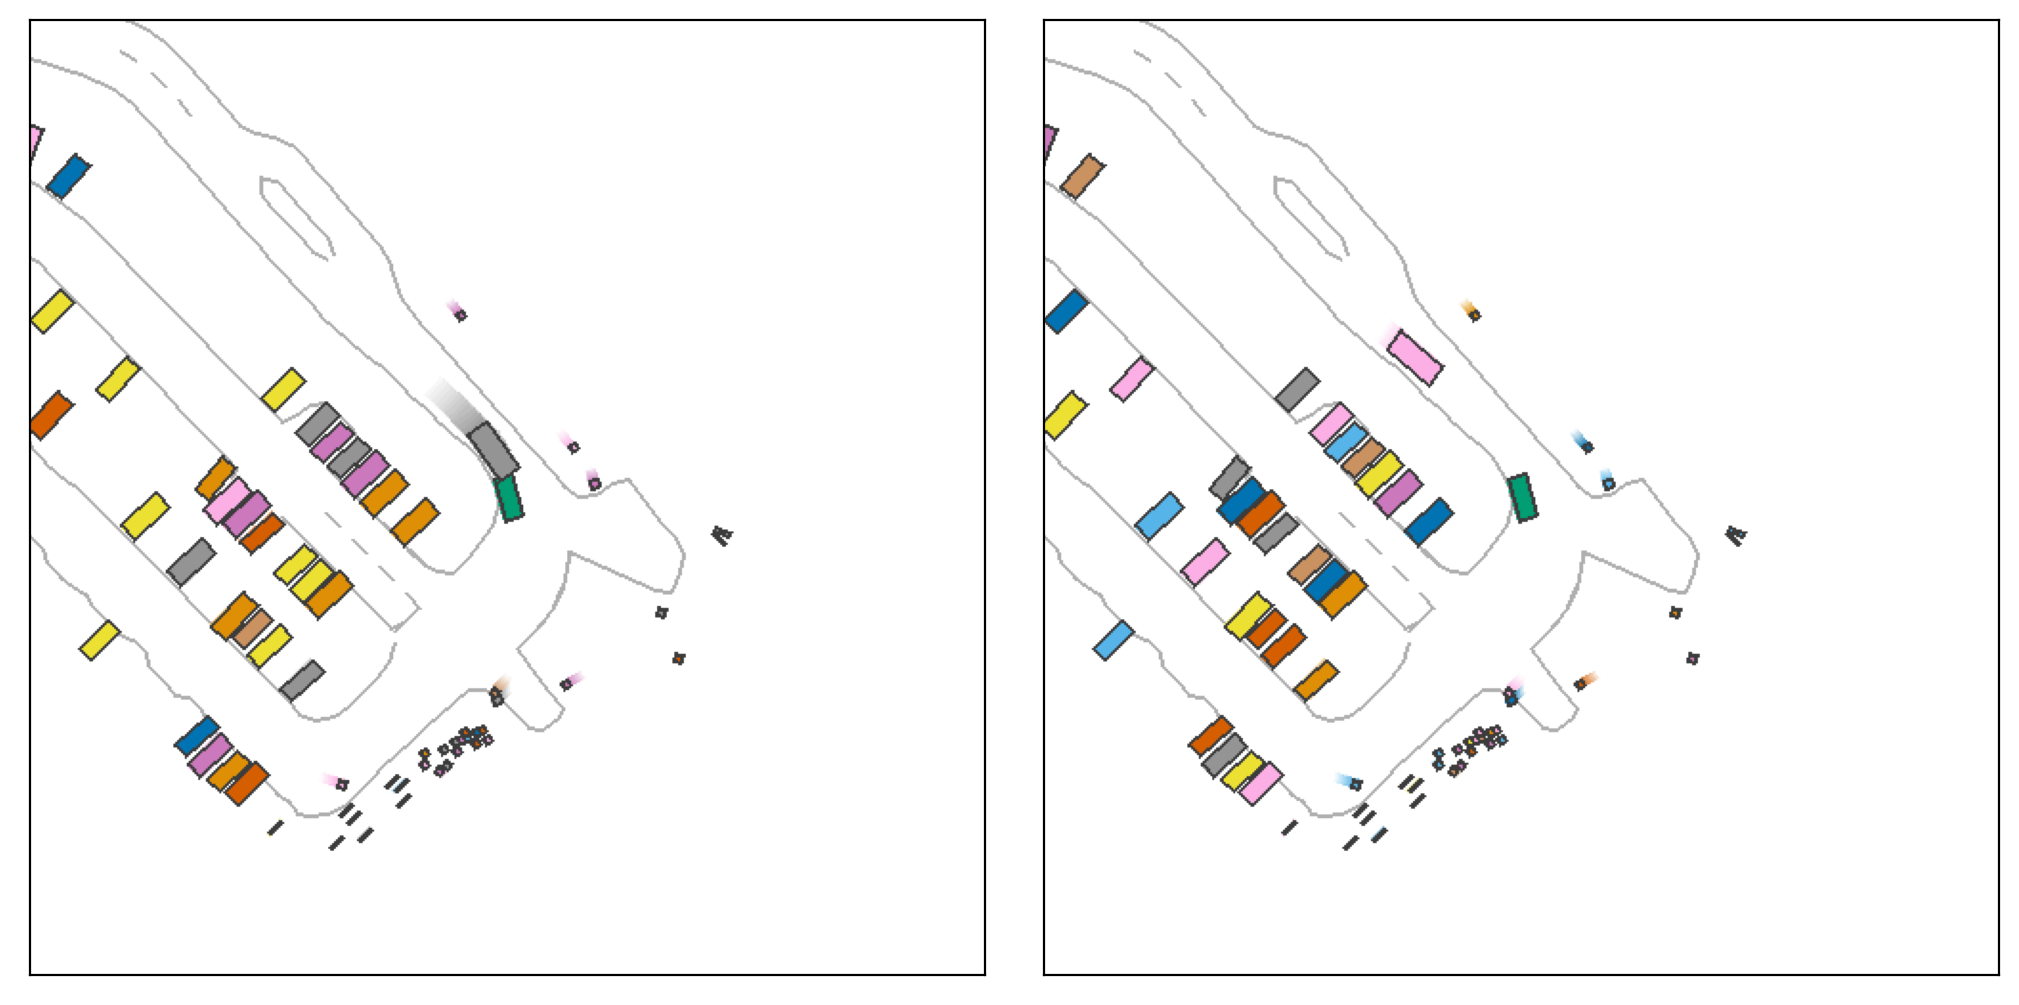

In [7]:
# visualization
import numpy as np
from metadrive.engine.asset_loader import AssetLoader
from metadrive.policy.replay_policy import ReplayEgoCarPolicy
from metadrive.envs.scenario_env import ScenarioEnv
import matplotlib.pyplot as plt
import time

nuscenes_data =  AssetLoader.file_path(AssetLoader.asset_path, "nuscenes", unix_style=False)
collide_step=None

def run_real_env(reactive):
    global collide_step
    env = ScenarioEnv(
        {
            "reactive_traffic": reactive,
            "data_directory": nuscenes_data,
            "start_scenario_index":6, # use scenario #6
            "num_scenarios": 1,
            "crash_vehicle_done": True,
            "log_level": 50,
        }
    )
    try:
        o, _ = env.reset(seed=6) # start simulation for senario #6
        for i in range(1, 300):
            o, r, tm, tc, info = env.step([.0, -1])
            ret=env.render(mode="top_down", 
                       screen_size=(500, 500),
                       semantic_map=False)
            if not reactive and tm:
                assert info["crash_vehicle"]
                collide_step=i
                break
            if i==collide_step:
                break
            time.sleep(0.02)
    finally:
        env.close()
    return ret

# draw
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
plt.tight_layout(pad=-1)

axs[0].imshow(run_real_env(False), cmap="bone")
axs[1].imshow(run_real_env(True), cmap="bone")
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()